In [1]:
import sys
assert sys.version_info >= (3,5)
import sklearn
assert sklearn.__version__ >= "0.20"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import scatter_matrix
import time
import cv2
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB 
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.model_selection import cross_val_score

In [2]:
binary_class_x_train=pd.read_csv('./Traffic_Sign/Binary_Classification/x_train_bin.csv')
binary_class_y_train=pd.read_csv('./Traffic_Sign/Binary_Classification/y_train_bin.csv')
binary_class_x_test=pd.read_csv('./Traffic_Sign/Binary_Classification/x_test_bin.csv')
binary_class_y_test=pd.read_csv('./Traffic_Sign/Binary_Classification/y_test_bin.csv')

complete_x_train=pd.read_csv('./Traffic_Sign/CompleteDataSet/x_train_all.csv')
complete_y_train=pd.read_csv('./Traffic_Sign/CompleteDataSet/y_train_all.csv')
complete_x_test=pd.read_csv('./Traffic_Sign/CompleteDataSet/x_test_all.csv')
complete_y_test=pd.read_csv('./Traffic_Sign/CompleteDataSet/y_test_all.csv')

onevsall_y_train_0=pd.read_csv('./Traffic_Sign/OnevrsAll/0_vrs_all/y_train_0.csv')
onevsall_y_train_1=pd.read_csv('./Traffic_Sign/OnevrsAll/1_vrs_all/y_train_1.csv')
onevsall_y_train_2=pd.read_csv('./Traffic_Sign/OnevrsAll/2_vrs_all/y_train_2.csv')
onevsall_y_train_3=pd.read_csv('./Traffic_Sign/OnevrsAll/3_vrs_all/y_train_3.csv')
onevsall_y_train_4=pd.read_csv('./Traffic_Sign/OnevrsAll/4_vrs_all/y_train_4.csv')
onevsall_y_train_5=pd.read_csv('./Traffic_Sign/OnevrsAll/5_vrs_all/y_train_5.csv')
onevsall_y_train_6=pd.read_csv('./Traffic_Sign/OnevrsAll/6_vrs_all/y_train_6.csv')
onevsall_y_train_7=pd.read_csv('./Traffic_Sign/OnevrsAll/7_vrs_all/y_train_7.csv')
onevsall_y_train_8=pd.read_csv('./Traffic_Sign/OnevrsAll/8_vrs_all/y_train_8.csv')
onevsall_y_train_9=pd.read_csv('./Traffic_Sign/OnevrsAll/9_vrs_all/y_train_9.csv')

# Specs assumes 0 is true and 1 is false. So we have to reverse that

def inverse_num(i):
    if i == 1: return 0
    else: return 1

onevsall_y_train_0 = [[inverse_num(i)] for i in onevsall_y_train_0.copy().to_numpy()]
onevsall_y_train_1 = [[inverse_num(i)] for i in onevsall_y_train_1.copy().to_numpy()]
onevsall_y_train_2 = [[inverse_num(i)] for i in onevsall_y_train_2.copy().to_numpy()]
onevsall_y_train_3 = [[inverse_num(i)] for i in onevsall_y_train_3.copy().to_numpy()]
onevsall_y_train_4 = [[inverse_num(i)] for i in onevsall_y_train_4.copy().to_numpy()]
onevsall_y_train_5 = [[inverse_num(i)] for i in onevsall_y_train_5.copy().to_numpy()]
onevsall_y_train_6 = [[inverse_num(i)] for i in onevsall_y_train_6.copy().to_numpy()]
onevsall_y_train_7 = [[inverse_num(i)] for i in onevsall_y_train_7.copy().to_numpy()]
onevsall_y_train_8 = [[inverse_num(i)] for i in onevsall_y_train_8.copy().to_numpy()]
onevsall_y_train_9 = [[inverse_num(i)] for i in onevsall_y_train_9.copy().to_numpy()]

complete_x_train = complete_x_train.astype('float') / 255
complete_x_test = complete_x_test.astype('float') / 255

In [3]:
def img_denoiser(arr):
    pixel_array = arr
    reshaped_array = pixel_array.reshape((48, 48))
    normalized_array = np.uint8(reshaped_array * 255)
    if normalized_array.ndim != 2:
        raise ValueError("The image should have 2 dimensions")
    thresholded_image = cv2.adaptiveThreshold(normalized_array, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    return thresholded_image

In [4]:
complete_x_train = np.apply_along_axis(
    func1d=lambda img: img_denoiser(img),
    axis=1, arr=complete_x_train).reshape(-1, 48*48)

complete_x_test = np.apply_along_axis(
    func1d=lambda img: img_denoiser(img),
    axis=1, arr=complete_x_test).reshape(-1, 48*48)

complete_x_train = complete_x_train.astype('float') / 255
complete_x_test = complete_x_test.astype('float') / 255

In [5]:
complete_x_train = pd.DataFrame(complete_x_train)
complete_x_test = pd.DataFrame(complete_x_test)

In [6]:
final_dataset = complete_x_train.copy()
final_dataset['class']=complete_y_train.copy()

In [7]:
def init_train_classifier(classifier, dataset_train_x, dataset_train_y):
    clf = None
    if classifier == "gaussian":
        clf = GaussianNB()
    elif classifier == "multinomial":
        clf = MultinomialNB()
    elif classifier == "complement":
        clf = ComplementNB()
    elif classifier == "categorical":
        clf = CategoricalNB(min_categories=10)
    else:
        raise ValueError(f"Unknown classifier: {classifier}")
    clf.fit(dataset_train_x, dataset_train_y)
    return clf

def run_naivebayes(classifier, dataset_train_x, dataset_train_y, dataset_test_x, dataset_test_y):
    clf = init_train_classifier(classifier, dataset_train_x, dataset_train_y)
    complete_y_pred = clf.predict(dataset_test_x)
    ret_arr = [
        accuracy_score(dataset_test_y, complete_y_pred), 
        precision_score(dataset_test_y, complete_y_pred, average='weighted'), 
        recall_score(dataset_test_y, complete_y_pred, average='weighted'),
        f1_score(dataset_test_y, complete_y_pred, average='weighted'),
        classification_report(dataset_test_y, complete_y_pred),
        confusion_matrix(dataset_test_y, complete_y_pred)
    ]
    return ret_arr

In [8]:
temp_dataset = final_dataset.groupby('class', group_keys=False)
avg_val = int(temp_dataset['class'].value_counts().mean())

balanced_dataset = pd.DataFrame()

for i in range(0,10):
    if (len(final_dataset[final_dataset['class']==i])<=avg_val):
        balanced_dataset = pd.concat([balanced_dataset, final_dataset[final_dataset['class']==i].sample(avg_val, replace=True)])
    else:
        balanced_dataset = pd.concat([balanced_dataset, final_dataset[final_dataset['class']==i].sample(avg_val)])

balanced_dataset_x = balanced_dataset.iloc[:,:2304]
balanced_dataset_y = balanced_dataset.iloc[:,2304:]


In [9]:
class_arr_data = [
                onevsall_y_train_0.copy(),
                onevsall_y_train_1.copy(),
                onevsall_y_train_2.copy(),
                onevsall_y_train_3.copy(),
                onevsall_y_train_4.copy(),
                onevsall_y_train_5.copy(),
                onevsall_y_train_6.copy(),
                onevsall_y_train_7.copy(),
                onevsall_y_train_8.copy(),
                onevsall_y_train_9.copy()
            ]

x_data = complete_x_train.copy()

def getTopFeatureMethod1(x,dataset,arr):
    return_arr = []
    for i in arr:
        bestfeatures = SelectKBest(score_func=chi2, k=x//len(arr))
        fit = bestfeatures.fit(dataset,i)
        dfscores = pd.DataFrame(fit.scores_)
        dfcolumns = pd.DataFrame(dataset.columns)
        featureScores = pd.concat([dfcolumns,dfscores],axis=1)
        featureScores.columns = ['Specs','Score']
        return_arr = np.unique(np.concatenate((return_arr,featureScores.nlargest(x//len(arr),'Score')['Specs']),0))
    return return_arr

def Remove_Outlier_Indices(df):
    Q1 = df.quantile(0.2)
    Q3 = df.quantile(0.8)
    IQR = Q3 - Q1
    trueList = ~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR)))
    return trueList

def getTopFeatureMethod2(x,dataset,arr):
    features_array = [[]]*10
    return_arr = [[]]*3
    for i in range (0,len(arr)):
        bestfeatures = SelectKBest(score_func=chi2, k=x//len(arr))
        fit = bestfeatures.fit(dataset,arr[i])
        dfscores = pd.DataFrame(fit.scores_)
        dfcolumns = pd.DataFrame(dataset.columns)
        featureScores = pd.concat([dfcolumns,dfscores],axis=1)
        featureScores.columns = ['Specs','Score']
        features_array[i]=featureScores.nlargest(x//len(arr),'Score')['Specs']
    for i in range (0,10):
        return_arr[0] = np.unique(np.concatenate((return_arr[0], features_array[i][0:x//len(arr)]),0))
        return_arr[1] = np.unique(np.concatenate((return_arr[1], features_array[i][0:x//(len(arr)*2)]),0))
        return_arr[2] = np.unique(np.concatenate((return_arr[2], features_array[i][0:x//(len(arr)*4)]),0))
    return return_arr

In [10]:
temp1 = getTopFeatureMethod1(400,x_data,class_arr_data)
temp2 = getTopFeatureMethod1(200,x_data,class_arr_data)
temp3 = getTopFeatureMethod1(125,x_data,class_arr_data)

temp = getTopFeatureMethod2(700,x_data,class_arr_data)

In [11]:
non_outlier1 = Remove_Outlier_Indices(balanced_dataset_x)
non_outlier2 = Remove_Outlier_Indices(complete_x_test)

In [12]:
balanced_dataset_x=balanced_dataset_x[non_outlier1]
balanced_dataset_x=balanced_dataset_x.fillna(0)

complete_x_test=complete_x_test[non_outlier2]
complete_x_test=complete_x_test.fillna(0)

In [13]:
nb=MultinomialNB()
arr=temp3

In [14]:
nb.fit(balanced_dataset_x[arr],balanced_dataset_y)

y_pred_nb=nb.predict(complete_x_test[arr])

print(accuracy_score(y_pred_nb,complete_y_test))
print(classification_report(y_pred_nb,complete_y_test))

0.6647249190938511
              precision    recall  f1-score   support

           0       0.75      0.31      0.44       144
           1       0.58      0.77      0.66       540
           2       0.72      0.73      0.72       739
           3       0.63      0.64      0.63       442
           4       0.67      0.80      0.73       549
           5       0.93      0.38      0.54       147
           6       0.64      0.46      0.53       127
           7       0.83      0.41      0.55       123
           8       0.69      0.79      0.73       131
           9       0.70      0.43      0.53       148

    accuracy                           0.66      3090
   macro avg       0.71      0.57      0.61      3090
weighted avg       0.68      0.66      0.66      3090



In [15]:
datasets = [
    [(balanced_dataset_x[temp1], complete_x_test[temp1]), (balanced_dataset_x[temp2], complete_x_test[temp2]), (balanced_dataset_x[temp3], complete_x_test[temp3])],
    [(balanced_dataset_x[temp[0]], complete_x_test[temp[0]]), (balanced_dataset_x[temp[1]], complete_x_test[temp[1]]), (balanced_dataset_x[temp[2]], complete_x_test[temp[2]])]
]

bayes = ["gaussian", "multinomial", "complement"]

for i in range (0,len(datasets)):
    print("*"*100)
    print("Using Method ",i+1)
    print("*"*100)
    for j in range (0,len(datasets[i])):
        for k in range (0,len(bayes)):
            temp = run_naivebayes(bayes[k], datasets[i][j][0], balanced_dataset_y, datasets[i][j][1], complete_y_test)
            print("Dataset",i+1,"\tMethod",j+1,"\t",bayes[k].capitalize(),"Naive Bayes","    \tAccuracy :",temp[0],"    \tPrecision :",temp[1],"    \tRecall Score :",temp[2],"    \tF1 Score :",temp[3])

****************************************************************************************************
Using Method  1
****************************************************************************************************
Dataset 1 	Method 1 	 Gaussian Naive Bayes     	Accuracy : 0.7333333333333333     	Precision : 0.7677305497722314     	Recall Score : 0.7333333333333333     	F1 Score : 0.7366003410630171
Dataset 1 	Method 1 	 Multinomial Naive Bayes     	Accuracy : 0.6880258899676376     	Precision : 0.7223610044629456     	Recall Score : 0.6880258899676376     	F1 Score : 0.6948085505223253
Dataset 1 	Method 1 	 Complement Naive Bayes     	Accuracy : 0.5941747572815534     	Precision : 0.7212356138524456     	Recall Score : 0.5941747572815534     	F1 Score : 0.6322491530103238
Dataset 1 	Method 2 	 Gaussian Naive Bayes     	Accuracy : 0.7313915857605178     	Precision : 0.7565611234659658     	Recall Score : 0.7313915857605178     	F1 Score : 0.7350902787985143
Dataset 1 	Method 2 	 Mul

<Figure size 1200x600 with 0 Axes>

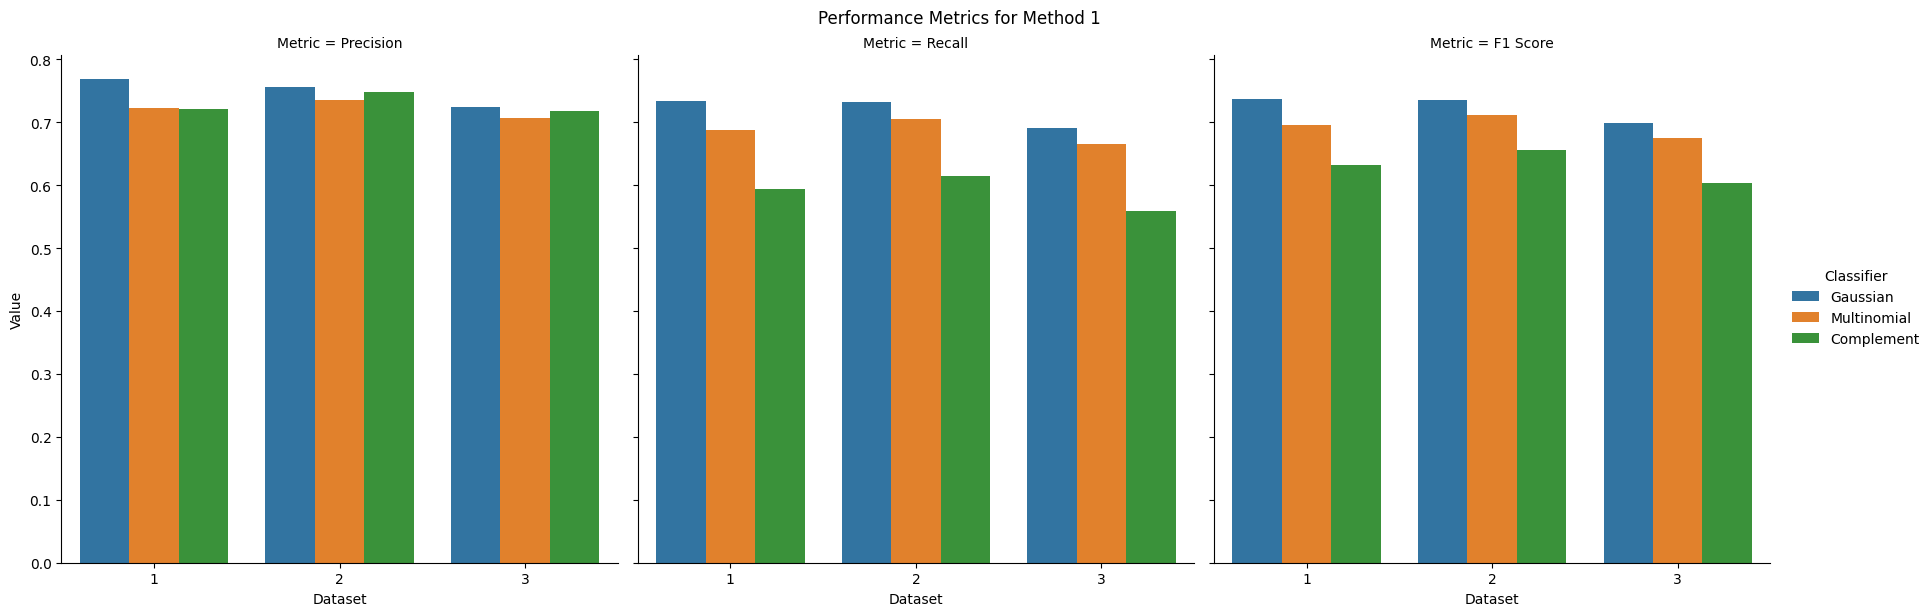

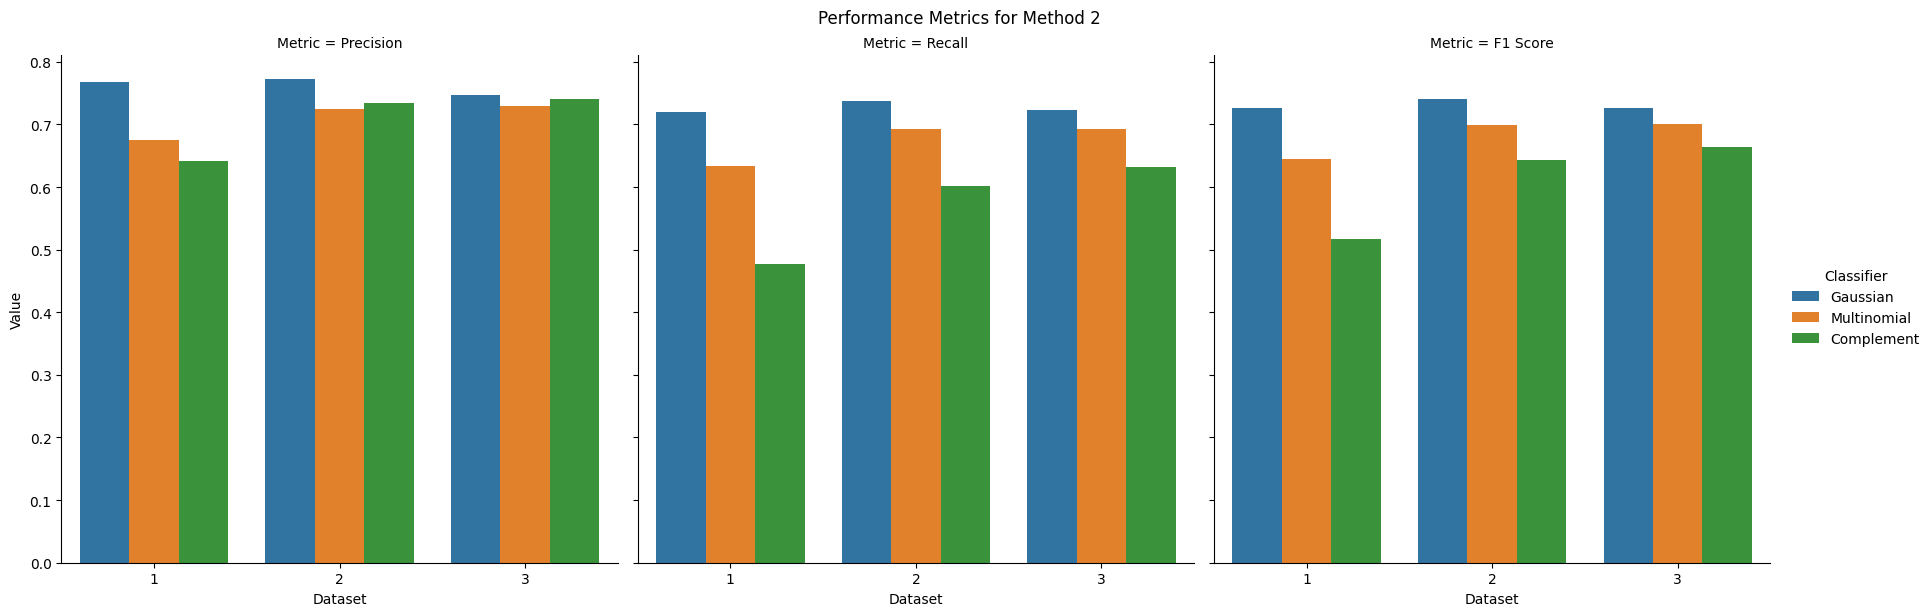

In [16]:
data_rows = []

for i in range(len(datasets)):
    method_num = i + 1
    for j in range(len(datasets[i])):
        dataset_num = j + 1
        for k in range(len(bayes)):
            classifier_name = bayes[k].capitalize()
            temp = run_naivebayes(bayes[k], datasets[i][j][0], balanced_dataset_y, datasets[i][j][1], complete_y_test)
            # Create a dictionary for this row, then add it to data_rows
            row_dict = {
                'Method': method_num,
                'Dataset': dataset_num,
                'Classifier': classifier_name,
                'Accuracy': temp[0],
                'Precision': temp[1],
                'Recall': temp[2],
                'F1 Score': temp[3]
            }
            data_rows.append(row_dict)

# Now create a DataFrame from data_rows
results_df = pd.DataFrame(data_rows)

# Now you can use seaborn or matplotlib to create your plots
import seaborn as sns

# Melt the DataFrame to have 'Metric' and 'Value' columns
melted_df = results_df.melt(id_vars=['Method', 'Dataset', 'Classifier'], value_vars=['Precision', 'Recall', 'F1 Score'], 
                            var_name='Metric', value_name='Value')

# Now create the plots
plt.figure(figsize=(12,6))

# Filter the melted_df for Method 1 and plot
sns.catplot(data=melted_df[melted_df['Method'] == 1], x='Dataset', y='Value', hue='Classifier', col='Metric', kind='bar', height=6, aspect=1)
plt.suptitle('Performance Metrics for Method 1', y=1.02)
plt.show()

# Filter the melted_df for Method 2 and plot
sns.catplot(data=melted_df[melted_df['Method'] == 2], x='Dataset', y='Value', hue='Classifier', col='Metric', kind='bar', height=6, aspect=1)
plt.suptitle('Performance Metrics for Method 2', y=1.02)
plt.show()

<Figure size 1500x700 with 0 Axes>

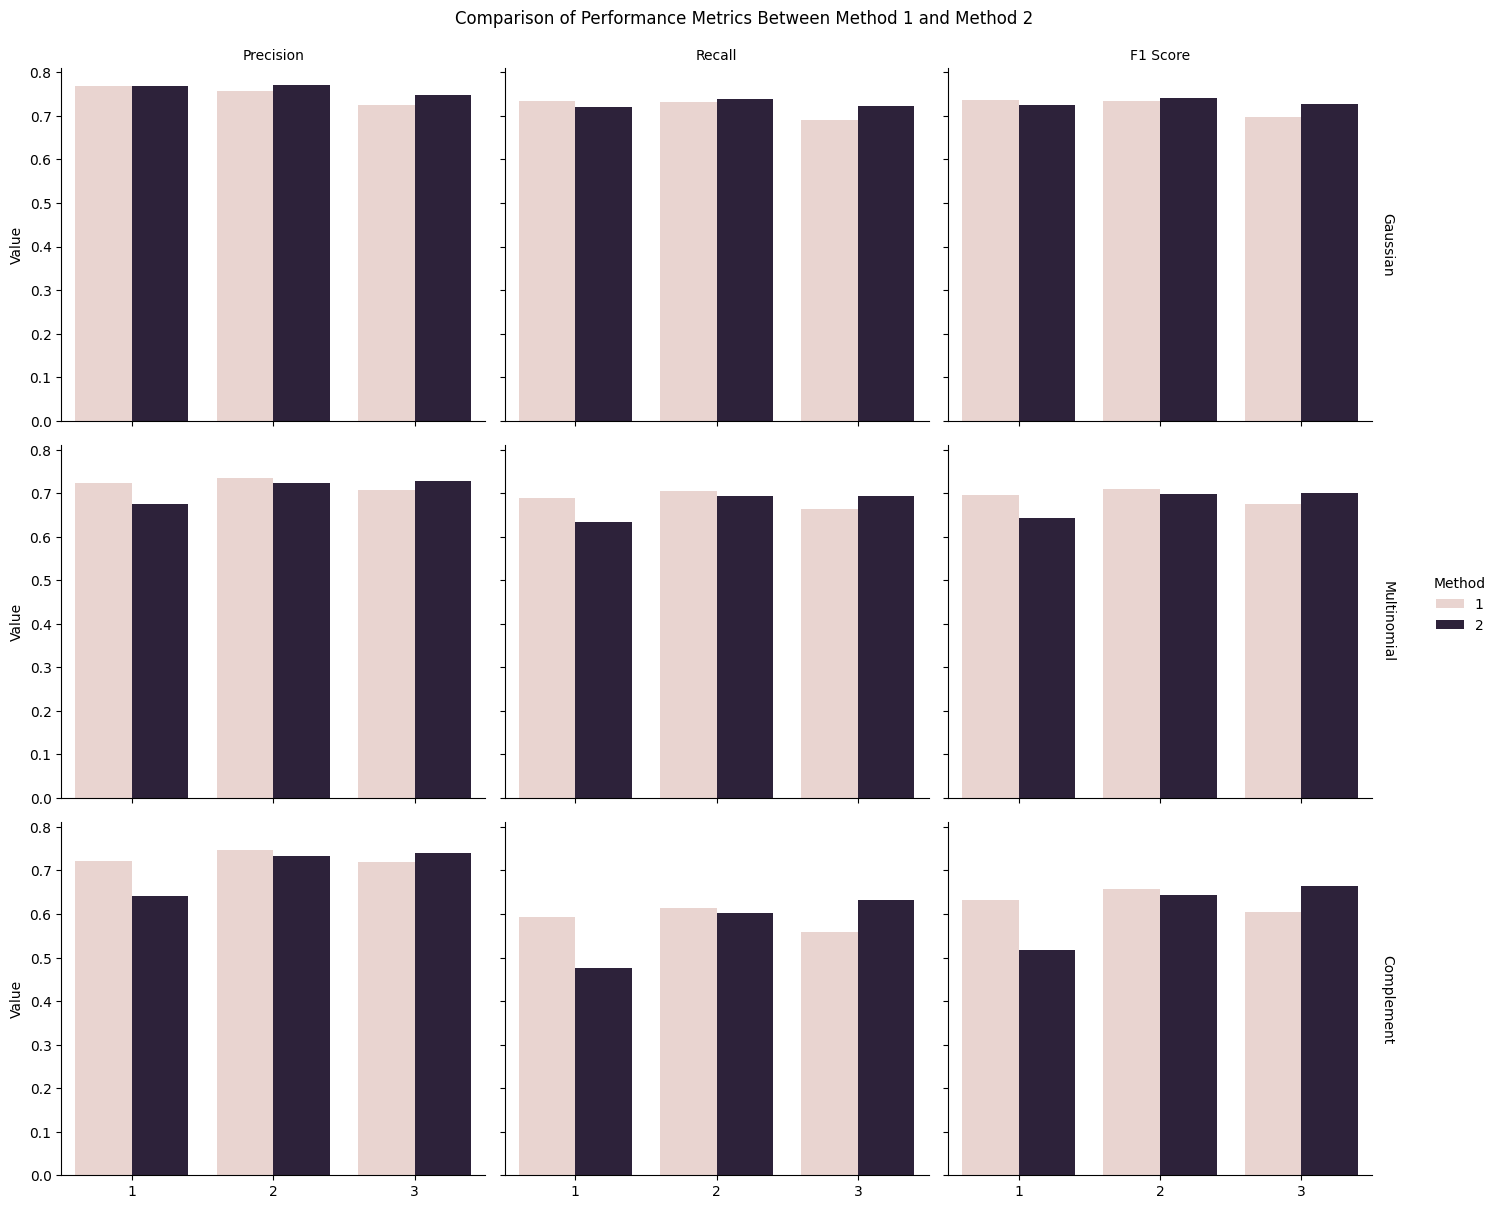

In [17]:
plt.figure(figsize=(15,7))

# Create a grouped bar plot
g = sns.catplot(
    data=melted_df, 
    x='Dataset', 
    y='Value', 
    hue='Method', 
    col='Metric', 
    row='Classifier', 
    kind='bar', 
    height=4, 
    aspect=1.2, 
    margin_titles=True
)

# Set titles and labels
g.fig.suptitle('Comparison of Performance Metrics Between Method 1 and Method 2', y=1.02)
g.set_axis_labels("", "Value")
g.set_titles(col_template="{col_name}", row_template="{row_name}")

plt.show()

Best Model: Method 2, Dataset 2, Classifier Gaussian


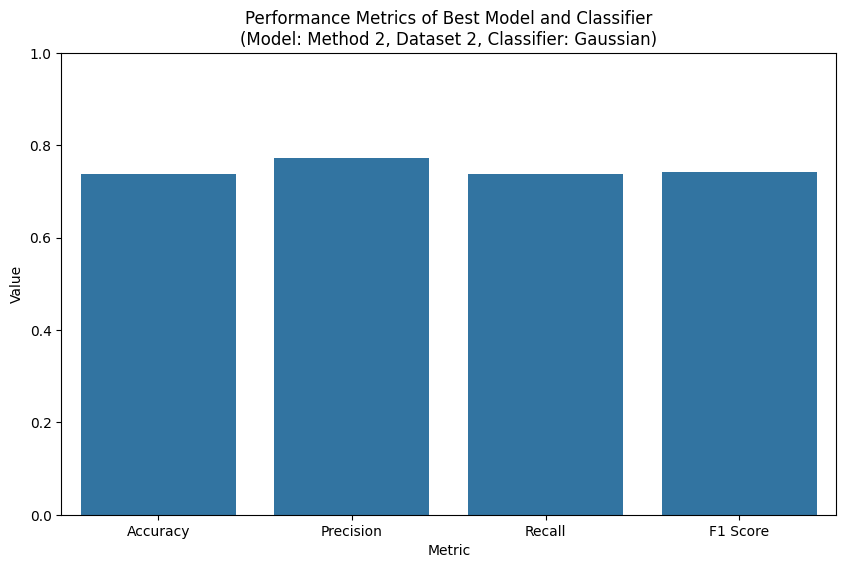

In [22]:
# Find the row with the highest F1 Score
best_row = results_df.loc[results_df['F1 Score'].idxmax()]

# Print the best model and classifier for reference
print(f"Best Model: Method {best_row['Method']}, Dataset {best_row['Dataset']}, Classifier {best_row['Classifier']}")

# Filter the results_df to only include the rows for the best model and classifier
best_df = results_df[(results_df['Method'] == best_row['Method']) & 
                     (results_df['Dataset'] == best_row['Dataset']) & 
                     (results_df['Classifier'] == best_row['Classifier'])]

# Melt the DataFrame to have a long-form DataFrame
melted_best_df = best_df.melt(id_vars=['Method', 'Dataset', 'Classifier'], 
                              value_vars=['Accuracy', 'Precision', 'Recall', 'F1 Score'], 
                              var_name='Metric', 
                              value_name='Value')

# Create the bar plot
plt.figure(figsize=(10,6))
sns.barplot(data=melted_best_df, x='Metric', y='Value', ci=None)

# Add title and labels
plt.title(f'Performance Metrics of Best Model and Classifier\n(Model: Method {best_row["Method"]}, Dataset {best_row["Dataset"]}, Classifier: {best_row["Classifier"]})')
plt.ylabel('Value')
plt.ylim(0, 1)  # Set y-axis limits to range from 0 to 1 for better interpretation

# Show the plot
plt.show()